# ML Lab 5 (Titanic) – Python/Jupyter

### Imports and global random seeds - Hye Ran Yoo

In [70]:
# Import OneHotEncoder for converting categorical columns to numeric (0/1) later
from sklearn.preprocessing import OneHotEncoder

# Use the new sklearn parameter name (sparse_output=False) so we get a dense array
ohe_cat = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Standard Python / data-science imports
import os, re, random, warnings
import numpy as np
import pandas as pd

### 1. Random seed : All random numbers were fixed at 2025 to secure reproducibility.

In [71]:
# Scikit-learn utilities for splitting data, building pipelines, and evaluating models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# Decision Tree model and plotting tools
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Optional: hide warnings to keep the notebook output clean for submission
warnings.filterwarnings("ignore")

# Set all random seeds so that results are reproducible
# (the lab says to use 2025 everywhere)
RANDOM_SEED = 2025
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print(f"Random seed set to {RANDOM_SEED}")

Random seed set to 2025


### 2. Load data and print stats : `Titanic.csv` and basic info

In [72]:
# Define file paths for the Titanic dataset
PREFERRED_PATH = "/mnt/data/Titanic.csv"   # uploaded path for this session
FALLBACK_PATH  = "./Titanic.csv"           # local run path

# Choose whichever file actually exists
DATA_PATH = PREFERRED_PATH if os.path.exists(PREFERRED_PATH) else FALLBACK_PATH

# Load the Titanic dataset into a pandas DataFrame
df = pd.read_csv(DATA_PATH)

# Print basic dataset information as required in the lab instructions
print("Loaded from:", DATA_PATH)
print("Number of instances:", len(df))          # total number of rows (records)
print("Number of attributes:", df.shape[1])     # total number of columns (features)
print("First 5 rows:")                          # show sample data for quick check
display(df.head())                              # display the first 5 rows nicely in Jupyter


Loaded from: ./Titanic.csv
Number of instances: 889
Number of attributes: 12
First 5 rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"'Braund, Mr. Owen Harris'",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"'Cumings, Mrs. John Bradley (Florence Briggs T...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"'Heikkinen, Miss. Laina'",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"'Futrelle, Mrs. Jacques Heath (Lily May Peel)'",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"'Allen, Mr. William Henry'",male,35.0,0,0,373450,8.0500,NaN,S


### 3. Quality check : Data quality check and remove irrelevant columns

In [73]:
# Check missing values for each column
print("Null counts per column:")
print(df.isna().sum())

# Keep only relevant columns for analysis
cols_keep = ["Survived","Pclass","Name","Sex","Age","SibSp","Parch","Fare","Embarked"]
df = df[cols_keep].copy()

print("\nColumns kept:", df.columns.tolist())


Null counts per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Columns kept: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


### 4. Creation of new columns :  Feature engineering for tree: AgeGroup, Relatives, FareBand

In [74]:
# Create engineered features (same logic as Lab 3)
# Relatives (Lab 3 style)
def make_relatives_group(sibsp, parch):
    total = (0 if pd.isna(sibsp) else sibsp) + (0 if pd.isna(parch) else parch)
    if total == 0:
        return "None"
    if total == 1:
        return "One"
    if total < 5:
        return "Few"
    return "Many"

df["Relatives"] = df.apply(
    lambda row: make_relatives_group(row["SibSp"], row["Parch"]),
    axis=1
)


def make_age_group(age):
    if pd.isna(age):
        return "NK"      # missing age
    if age < 3:
        return "Baby"
    if age < 13:
        return "Child"
    if age < 20:
        return "Teen"
    if age <= 60:
        return "Adult"
    return "Senior"

df["AgeGroup"] = df["Age"].apply(make_age_group)

def fare_band(f):
    if pd.isna(f):
        return "Unknown"
    if f == 0:
        return "Free"
    if f < 50:
        return "Low"
    if f < 100:
        return "Average"
    return "High"

df["FareBand"] = df["Fare"].apply(fare_band)


### 5. First 5 rows

In [75]:
# dataset for decision tree
tree_df = df[["Survived","Pclass","Sex","AgeGroup","Relatives","FareBand","Embarked"]].copy()
print("Tree DF preview:")
display(tree_df.head())

Tree DF preview:


,Survived,Pclass,Sex,AgeGroup,Relatives,FareBand,Embarked
0,0,3,male,Adult,One,Low,S
1,1,1,female,Adult,One,Average,C
2,1,3,female,Adult,None,Low,S
3,1,1,female,Adult,One,Average,S
4,0,3,male,Adult,None,Low,S


### 6. One-hot encoding: Decision Tree: one-hot encode categoricals, split, fit, evaluate

In [76]:
# Split features/target for the tree model
X_tree = tree_df.drop(columns=["Survived"])
y_tree = tree_df["Survived"].astype(int)

def make_ohe():
    # scikit-learn 1.4+ : sparse_output=False
    return OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Categorical and numeric columns
cat_cols = ["Pclass","Sex","AgeGroup","Relatives","FareBand","Embarked"]
num_cols = []

# One-hot encode categorical columns, keep numeric as-is
preprocess_tree = ColumnTransformer(
    transformers=[
        ("cat", make_ohe(), cat_cols),
    ],
    remainder="drop"
)

## 7. Train-test split

In [77]:
# Train/test split (same seed as lab spec)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_tree, y_tree,
    test_size=0.25,
    random_state=RANDOM_SEED,
    stratify=y_tree
)

## 8. Model fitting

In [78]:
# Decision tree with limited depth for readability
dt_clf = DecisionTreeClassifier(
    random_state=RANDOM_SEED
)

# Full pipeline = preprocessing + model
tree_pipe = Pipeline(steps=[
    ("prep", preprocess_tree),
    ("model", dt_clf),
])

# Train
tree_pipe.fit(X_train_t, y_train_t)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 9. Prediction, accuracy, confusion matrix

In [79]:
# Test
y_pred_t = tree_pipe.predict(X_test_t)
acc_t = accuracy_score(y_test_t, y_pred_t)
cm_t = confusion_matrix(y_test_t, y_pred_t)

print(f"Decision Tree accuracy: {acc_t:.4f}")
print("Confusion Matrix (Decision Tree):")
print(cm_t)

Decision Tree accuracy: 0.7803
Confusion Matrix (Decision Tree):
[[120  18]
 [ 31  54]]


## 10. Tree: Visualize the decision tree  

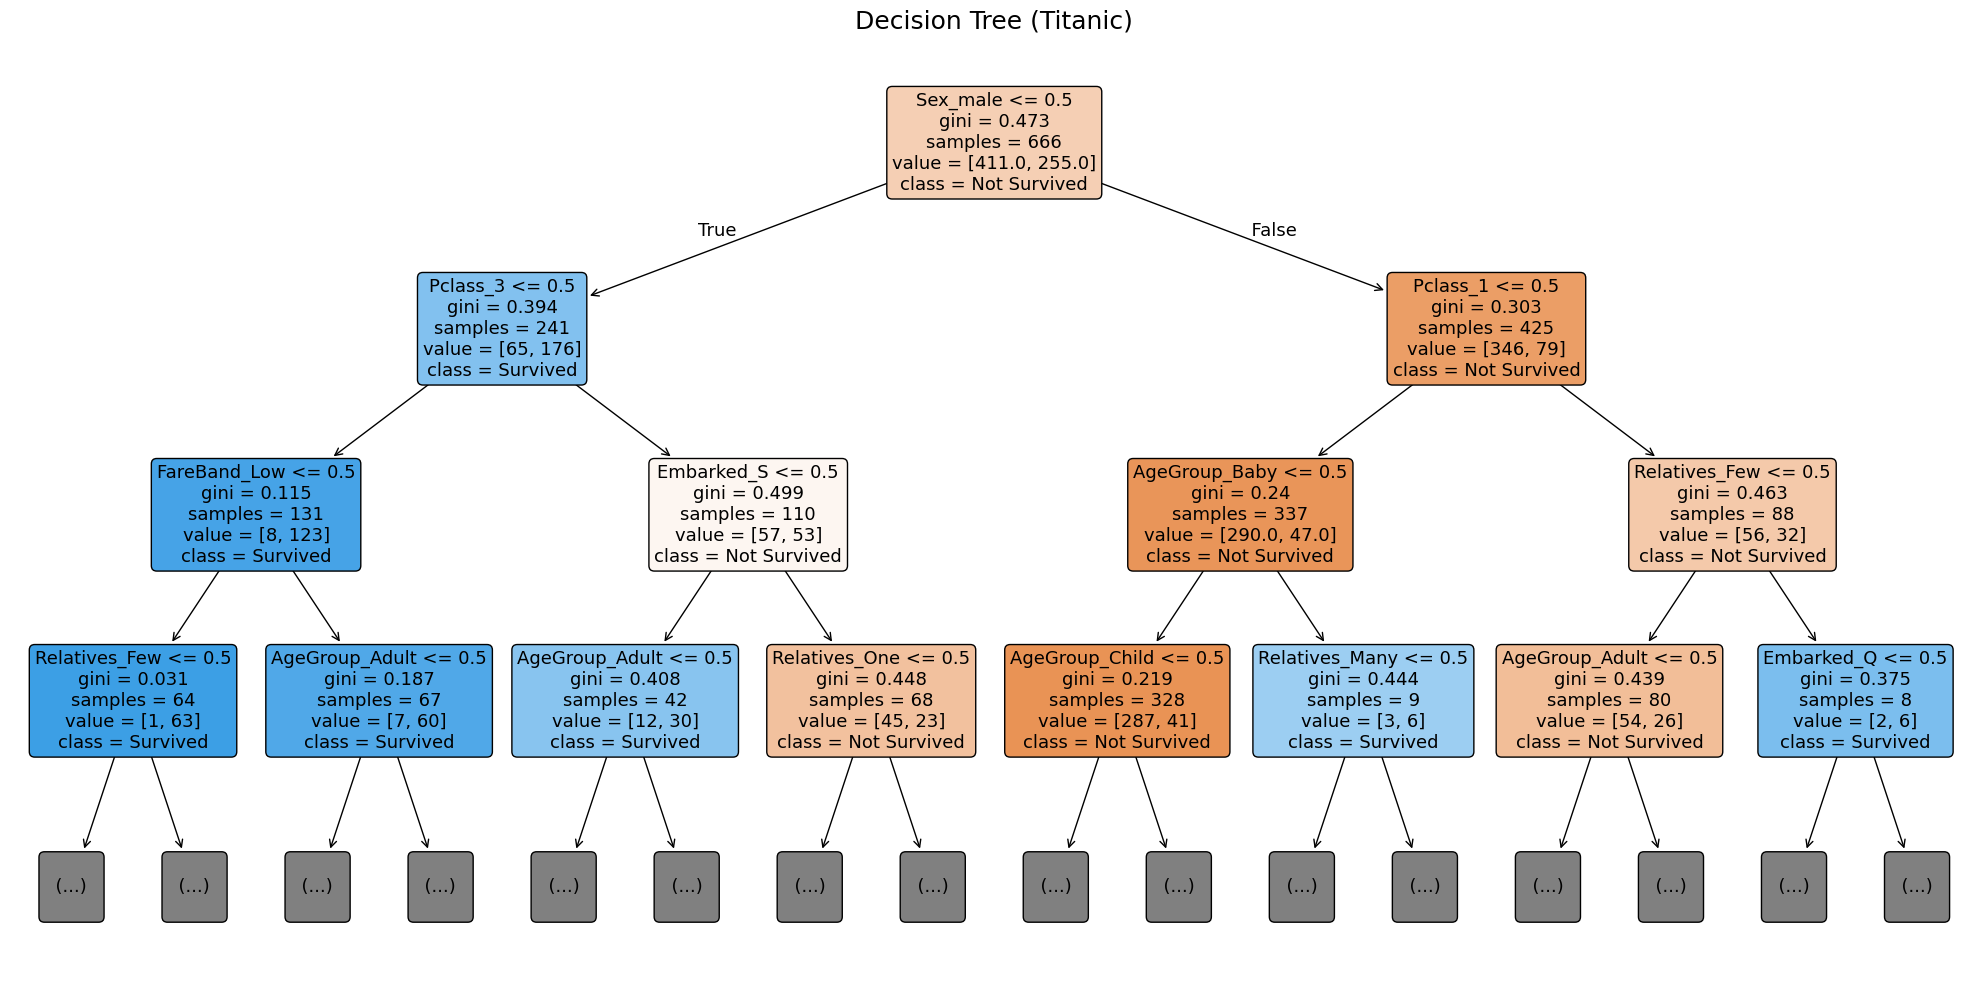

In [80]:
# Get the fitted preprocessor and recover the expanded (one-hot) feature names
prep = tree_pipe.named_steps["prep"]
ohe = prep.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = ohe_feature_names + num_cols

# Get the trained decision tree from the pipeline
fitted_tree = tree_pipe.named_steps["model"]

# Plot the tree so it is easy to read in the report
plt.figure(figsize=(20, 10))
plot_tree(
    fitted_tree,
    feature_names=feature_names,
    class_names=["Not Survived", "Survived"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=13
)
plt.title("Decision Tree (Titanic)", fontsize=18, pad=15)
plt.tight_layout()
plt.show()


# 11. 5 rules : Print example rules

In [81]:
# Export the trained decision tree as text rules (up to depth 4)
rules_text = export_text(fitted_tree, feature_names=feature_names, max_depth=4)
print(rules_text[:2000])   # print only the first part so the output is not too long

# Helper to pick a few leaf rules for the answer document
def extract_leaf_paths(text, max_rules=5):
    rules = []
    for line in text.splitlines():
        if "class:" in line and len(rules) < max_rules:
            rules.append(line.strip())
        if len(rules) >= max_rules:
            break
    return rules

# Show 5 sample rules that we can rewrite in plain English
sample_leaf_summaries = extract_leaf_paths(rules_text, max_rules=5)
print("\nFive leaf summaries (use these to write human-readable rules):")
for i, r in enumerate(sample_leaf_summaries, 1):
    print(f"{i}. {r}")


|--- Sex_male <= 0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- FareBand_Low <= 0.50
|   |   |   |--- Relatives_Few <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Relatives_Few >  0.50
|   |   |   |   |--- FareBand_High <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- FareBand_High >  0.50
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |--- FareBand_Low >  0.50
|   |   |   |--- AgeGroup_Adult <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- AgeGroup_Adult >  0.50
|   |   |   |   |--- Relatives_Few <= 0.50
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- Relatives_Few >  0.50
|   |   |   |   |   |--- truncated branch of depth 2
|   |--- Pclass_3 >  0.50
|   |   |--- Embarked_S <= 0.50
|   |   |   |--- AgeGroup_Adult <= 0.50
|   |   |   |   |--- Embarked_C <= 0.50
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |--- Embarked_C >  0.50
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- 

## 12. Data prep for distance-based approach : kNN preparation 

In [82]:
# Start from the cleaned dataset for the kNN part
base = df.copy()
base["Relatives"] = base["SibSp"].fillna(0) + base["Parch"].fillna(0)

# Keep only the columns needed for distance-based methods
knn_df = base[["Survived","Pclass","Sex","Age","Relatives","Fare","Embarked","Name"]].copy()
print("Preview (pre-imputation):")
display(knn_df.head())

# split first
feature_cols = ["Pclass","Sex","Age","Relatives","Fare","Embarked","Name"]
X = knn_df[feature_cols].copy()
y = knn_df["Survived"].astype(int).copy()

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_SEED,
    stratify=y
)


Preview (pre-imputation):


,Survived,Pclass,Sex,Age,Relatives,Fare,Embarked,Name
0,0,3,male,22.0,1,7.2500,S,"'Braund, Mr. Owen Harris'"
1,1,1,female,38.0,1,71.2833,C,"'Cumings, Mrs. John Bradley (Florence Briggs T..."
2,1,3,female,26.0,0,7.9250,S,"'Heikkinen, Miss. Laina'"
3,1,1,female,35.0,1,53.1000,S,"'Futrelle, Mrs. Jacques Heath (Lily May Peel)'"
4,0,3,male,35.0,0,8.0500,S,"'Allen, Mr. William Henry'"


## 13. Handle missing age: Extract Title from Name and impute Age by title-specific average

In [83]:
# 1) define helper FIRST
import re

def extract_title(name):
    if pd.isna(name):
        return "Unknown"
    m = re.search(r",\s*([^\.]+)\.", str(name))
    if m:
        t = m.group(1).strip()
        mapping = {
            "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
            "Lady": "Royalty", "Countess": "Royalty",
            "Sir": "Royalty", "Jonkheer": "Royalty", "Don": "Royalty", "Dona": "Royalty",
            "Capt": "Officer", "Col": "Officer", "Major": "Officer",
            "Dr": "Officer", "Rev": "Officer",
        }
        return mapping.get(t, t)
    return "Unknown"

# extract title for the whole dataset
knn_df["Title"] = knn_df["Name"].apply(extract_title)

# compute title-based average age using all rows with valid age
title_age_mean = (
    knn_df.loc[knn_df["Age"].notna()]
    .groupby("Title")["Age"]
    .mean()
)

def impute_age(row):
    if pd.notna(row["Age"]):
        return row["Age"]
    t = row["Title"]
    if t in title_age_mean.index:
        return title_age_mean.loc[t]
    return knn_df["Age"].median()

knn_df["Age"] = knn_df.apply(impute_age, axis=1)


### 14. Scaling

In [84]:
num_cols_knn = ["Age", "Relatives", "Fare"]
cat_cols_knn = ["Pclass", "Sex", "Embarked"]

numeric_transformer = ("num", StandardScaler(), num_cols_knn)

### 15. One-hot encoding 

In [85]:
categorical_transformer = ("cat", make_ohe(), cat_cols_knn)

preprocess_knn = ColumnTransformer(
    transformers=[
        numeric_transformer,        # step 14
        categorical_transformer,    # step 15
    ],
    remainder="drop"
)

### 16. kNN fit & predict

In [86]:
# 14. Scaling (with impute)
num_cols_knn = ["Age", "Relatives", "Fare"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # NaN → median (from train)
    ("scaler", StandardScaler()),
])

# 15. One-hot encoding (with impute)
cat_cols_knn = ["Pclass", "Sex", "Embarked"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # NaN → most frequent
    ("ohe", make_ohe()),
])

preprocess_knn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_knn),   # step 14
        ("cat", categorical_transformer, cat_cols_knn),  # step 15
    ],
    remainder="drop",
)

# 16. kNN fit & predict
knn_clf = KNeighborsClassifier(n_neighbors=5, weights="uniform")

knn_pipe = Pipeline(steps=[
    ("prep", preprocess_knn),
    ("model", knn_clf),
])

knn_pipe.fit(X_train_k, y_train_k)

y_pred_k = knn_pipe.predict(X_test_k)
acc_k = accuracy_score(y_test_k, y_pred_k)
cm_k = confusion_matrix(y_test_k, y_pred_k)

print(f"kNN accuracy: {acc_k:.4f}")
print("Confusion Matrix (kNN):")
print(cm_k)


kNN accuracy: 0.8072
Confusion Matrix (kNN):
[[122  16]
 [ 27  58]]


### 17.0 Bonus: install the CatBoost

In [87]:
!pip install catboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 17. Bonus: Tree that handles nominal columns without one-hot (CatBoost)

In [88]:
try:
    from catboost import CatBoostClassifier
    from sklearn.metrics import accuracy_score, confusion_matrix

    # simple dataset for CatBoost (no one-hot)
    bonus_df = df[["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]].copy()
    bonus_df["Relatives"] = bonus_df["SibSp"].fillna(0) + bonus_df["Parch"].fillna(0)
    bonus_df = bonus_df.drop(columns=["SibSp","Parch"])

    # basic imputations
    bonus_df["Age"] = bonus_df["Age"].fillna(bonus_df["Age"].median())
    bonus_df["Embarked"] = bonus_df["Embarked"].fillna("Unknown")
    bonus_df["Sex"] = bonus_df["Sex"].fillna("Unknown")

    Xb = bonus_df.drop(columns=["Survived"])
    yb = bonus_df["Survived"].astype(int)

    Xb_train, Xb_test, yb_train, yb_test = train_test_split(
        Xb, yb,
        test_size=0.25,
        random_state=RANDOM_SEED,
        stratify=yb
    )

    # categorical columns (by index)
    cat_features = [Xb.columns.get_loc(c) for c in ["Pclass","Sex","Embarked"]]

    model = CatBoostClassifier(
        random_seed=RANDOM_SEED,
        verbose=False
    )
    model.fit(Xb_train, yb_train, cat_features=cat_features)

    yb_pred = model.predict(Xb_test).astype(int)

    acc_b = accuracy_score(yb_test, yb_pred)
    cm_b = confusion_matrix(yb_test, yb_pred)

    print(f"CatBoost (bonus) accuracy: {acc_b:.4f}")
    print("Confusion Matrix (CatBoost):")
    print(cm_b)

except Exception as e:
    print("CatBoost not available – bonus skipped.")
    print("Error:", e)


CatBoost (bonus) accuracy: 0.8206
Confusion Matrix (CatBoost):
[[130   8]
 [ 32  53]]
